# Generating synthetic metaorders from synthetic trade data

<div style="font-size:120%">

We provide below the code used to reproduce **Figure 8** from [Generating realistic metaorders from synthetic data](https://arxiv.org/pdf/2503.18199).  
As noted in the article, generating synthetic metaorders from a synthetic price does **not** yield the observed square-root law (SQL).  
However, replacing the synthetic price with **real trade data**-while keeping the same algorithm—allows one to recover the results presented in the paper. 

When working with real trade data, we recommend the following preprocessing steps:

- Rescale trade sizes by the corresponding daily traded volume  
- Transform prices by taking the logarithm and rescaling by the daily volatility

</div>


In [104]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.stats import powerlaw

In [137]:
def generate_meta (nb_iter,exp_impact):

    ### Generate a synthetic price
    sign = 2*np.random.randint(0,2,nb_iter)-1
    vol = np.random.randint(10,100,nb_iter)   
    df = pd.DataFrame({'sign':sign, 'vol':vol})
    df['price'] = df['sign']*df['vol']**exp_impact
    df['price'] = df['price'].cumsum()

    ### Attribute to each trade a trader thanks to a mapping function
    df['trader'] = mapping_function(df,4,'power',2)
    df['counter'] = np.arange(len(df))  

    ### Aggregate metaorders
    t  = df.sort_values(['trader','counter']).reset_index(drop=True)
    t['metaid'] = np.where((t['trader']!=t['trader'].shift())|( t.sign.shift()!= t.sign),1,0).cumsum()
    t['price_last'] = t['price']
    t = t.groupby('metaid').agg({'price':'first','price_last':'last',
                                 'vol':'sum','counter':'count','sign':'first'}).reset_index()
    t['rImp'] = (t.price_last-t.price)*t.sign
    t = t[t.counter > 2].reset_index(drop=True)
    t['bins_vol'] = pd.cut(t.vol,
                           np.logspace(np.log10(t.vol.min()),np.log10(t.vol.max()),100))
    print('Number of metaorders ',len(t))
    r =t.groupby('bins_vol').agg({'rImp':'mean','vol':'mean'}).reset_index()
    return r


In [138]:
def mapping_function(df,nb_traders,kind,alpha) :
    ###Choose a trading frequency distribution
    if kind == 'power':
        samples = powerlaw.rvs(int(alpha), size=int(nb_traders))
    if kind =='uniform':
        samples = np.ones(nb_traders)
    frequencies = samples / samples.sum()
    cum_freq = np.cumsum(frequencies)
    traders = []
    ###Assign traders to trades
    for _ in range (len(df)):
        u = random.random()
        trader_index = np.searchsorted(cum_freq,u)
        traders.append(f"Trader {trader_index+1}")
    return traders

In [134]:
x = generate_meta(5*10**6,0.5)

Number of metaorders  624233


/var/folders/35/189hm_7d11zcnls6gqk_9btc0000gp/T/ipykernel_4430/576150675.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  r =t.groupby('bins_vol').agg({'rImp':'mean','vol':'mean'}).reset_index()


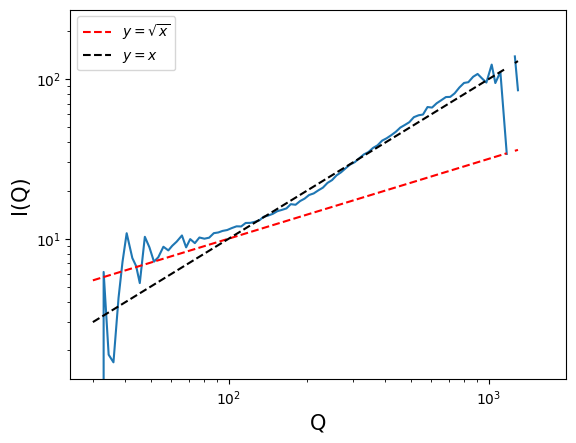

In [135]:
plt.plot(x.vol,x.rImp)
plt.plot(x.vol,x.vol**0.5,'r--',label = r'$y=\sqrt{x}$')
plt.plot(x.vol,0.1*x.vol,'k--',label = r'$y=x$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Q',fontsize = 15)
plt.ylabel('I(Q)',fontsize = 15)
plt.legend()